In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For plotting later

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.datasets import FER2013
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

TRAIN_CSV_PATH = "../data/fer2013/fer2013_training_onehot.csv"
NUM_CLASSES = 7 # 0:Angry, 1:Disgust, 2:Fear, 3:Happy, 4:Sad, 5:Surprise, 6:Neutral
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 500                                  
IMG_SIZE = 48
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.6) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


Using device: cpu


In [5]:
data = pd.read_csv(TRAIN_CSV_PATH, header=None)
data.shape

(28709, 2311)

In [7]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, subset=None, transform=None):
        self.data_frame = pd.read_csv(csv_file, header=None)
        nrow, ncol = self.data_frame.shape
        self.labels = self.data_frame[self.data_frame.columns[(ncol - 7):(ncol + 1)]]
        self.data_frame.drop(self.data_frame.columns[(ncol - 7):(ncol + 1)], axis=1, inplace=True)

        if(subset is not None):
            self.data_frame = self.data_frame.iloc[subset]
            self.labels = self.labels.iloc[subset]
        self.transform = transform
        
        # Convert pixel strings to numpy arrays
        self.pixels = self.data_frame.to_numpy(dtype=np.uint8).reshape(-1, IMG_SIZE, IMG_SIZE)
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        image = self.pixels[idx,:,:]
        label = self.labels.iloc[idx,:].to_numpy().argmax()

        image = Image.fromarray(image).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

# For training data, include augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizing for grayscale
])

# For validation and test data, only basic transforms
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

try:
    train_dataset = FER2013Dataset(csv_file=TRAIN_CSV_PATH, subset=list(range(0,20001,1)), transform=train_transform)
    val_dataset = FER2013Dataset(csv_file=TRAIN_CSV_PATH, subset=list(range(28001,28709,1)), transform=val_test_transform)
    # test_dataset = FER2013Dataset(csv_file=TEST_CSV_PATH, usage='PrivateTest', transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    # test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Training data size: {len(train_dataset)}")
    print(f"Validation data size: {len(val_dataset)}")
    # print(f"Test data size: {len(test_dataset)}")

except FileNotFoundError:
    print("Error: fer2013.csv not found. Please download it and place it in the correct directory.")
    exit()


Training data size: 20001
Validation data size: 708


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1 input channel (grayscale)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 48x48 -> 24x24

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 24x24 -> 12x12

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 12x12 -> 6x6

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # Added layer
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 6x6 -> 3x3

        self.flatten = nn.Flatten()
        # The input features to the fc layer depend on the output size of the last pooling layer
        # For 3x3 output from pool4 with 256 channels: 256 * 3 * 3
        self.fc1 = nn.Linear(256 * (IMG_SIZE // 16) * (IMG_SIZE // 16), 1024) # //16 because 4 pooling layers (2*2*2*2)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.flatten(x)
        x = self.dropout(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4)

Epoch [1/10]:
  Train Loss: 2.3732, Train Acc: 17.88%
  Val Loss: 1.8680, Val Acc: 27.50%
  New best model saved to fer2013_best_model.pth with Val Acc: 27.50%
Epoch [2/10]:
  Train Loss: 1.9414, Train Acc: 20.28%
  Val Loss: 1.8165, Val Acc: 25.60%
Epoch [3/10]:
  Train Loss: 1.8127, Train Acc: 21.28%
  Val Loss: 1.8047, Val Acc: 20.20%
Epoch [4/10]:
  Train Loss: 1.8192, Train Acc: 20.98%
  Val Loss: 1.7794, Val Acc: 27.70%
  New best model saved to fer2013_best_model.pth with Val Acc: 27.70%
Epoch [5/10]:
  Train Loss: 1.8070, Train Acc: 22.28%
  Val Loss: 1.8097, Val Acc: 23.90%
Epoch [6/10]:
  Train Loss: 1.8028, Train Acc: 22.48%
  Val Loss: 1.7945, Val Acc: 27.30%
Epoch [7/10]:
  Train Loss: 1.7908, Train Acc: 23.98%
  Val Loss: 1.7766, Val Acc: 27.60%
Epoch [8/10]:
  Train Loss: 1.7959, Train Acc: 22.98%
  Val Loss: 1.7607, Val Acc: 29.50%
  New best model saved to fer2013_best_model.pth with Val Acc: 29.50%
Epoch [9/10]:
  Train Loss: 1.7955, Train Acc: 24.78%
  Val Loss: 1.78

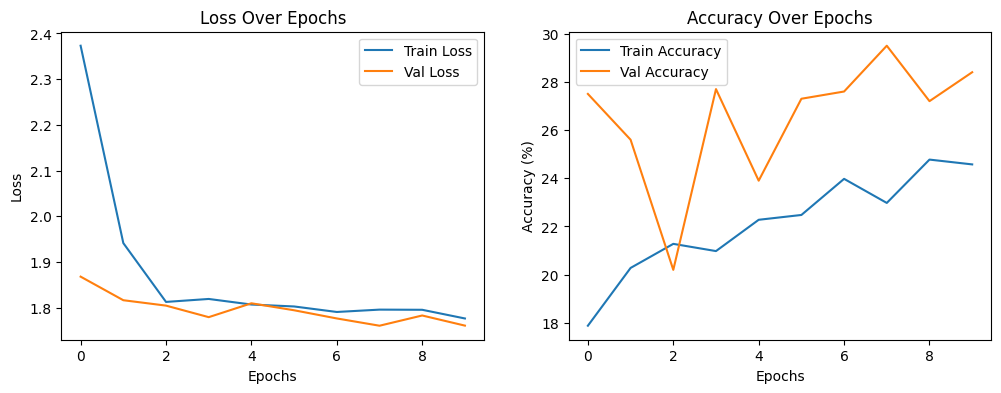

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5) # Learning rate scheduler

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_model_path = "fer2013_best_model.pth"

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad(): # No gradients needed for validation
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())


        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Save the model if validation accuracy improves
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f'  New best model saved to {best_model_path} with Val Acc: {best_val_accuracy:.2f}%')

        # Early stopping (optional, simple version)
        # if epoch > 10 and val_losses[-1] > val_losses[-2] > val_losses[-3]: # if val loss starts increasing
        #     print("Early stopping triggered.")
        #     break

    print('Finished Training')
    return train_losses, val_losses, train_accuracies, val_accuracies, best_model_path

# --- Start Training ---
if 'train_loader' in locals(): # Check if data loading was successful
    train_losses, val_losses, train_accuracies, val_accuracies, best_model_path = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

    # --- Plotting Training History ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    plt.show()
else:
    print("Skipping training due to data loading issues.")